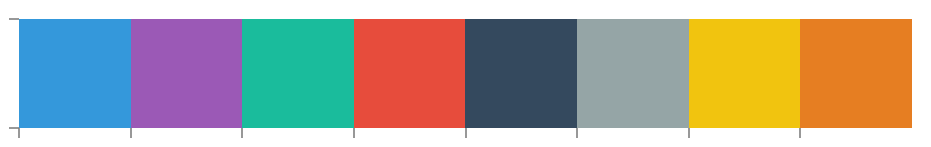

In [12]:
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
# plt.style.use("seaborn-poster") ### Use this for figures used in posters
plt.style.use("seaborn-paper") ### Use this for figures used in paper
# plt.style.use("seaborn-talk") ### Use this for figures used in presentations/talks
import scipy.misc
from sargan_models import SARGAN
from utils import imsave
import tensorflow as tf
import numpy as np
import time
import sys
from tqdm import tqdm
from sar_utilities import to_dB, visualize_raw_data, get_spectrum, \
    visualize_raw_data_spectrum, insert_freq_gaps, \
    generate_raw_data_from_dict, downsample, snr, \
    add_gaussian_noise, preprocess_train, preprocess_test, \
    generate_raw_data
import math
from alert_utilities import send_images_via_email
import time
import scipy.io as sio
%matplotlib inline
%config InlineBackend.figure_format = "retina"

mpl.rcParams["axes.grid"] = False
mpl.rcParams["grid.color"] = "#f5f5f5"
mpl.rcParams["axes.facecolor"] = "#ededed"
mpl.rcParams["axes.spines.left"] = False
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.bottom"] = False
mpl.rcParams['axes.labelcolor'] = "grey"
mpl.rcParams['xtick.color'] = 'grey'
mpl.rcParams['ytick.color'] = 'grey'
mpl.rcParams["figure.figsize"] = [4, 3]
from cycler import cycler
import seaborn as sns
# color_palette = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
# color_palette = sns.color_palette("deep", 10)
# color_palette = sns.color_palette("Set1")
color_palette = ["#3498db", "#9b59b6", "#1abc9c", "#e74c3c", "#34495e", "#95a5a6", "#f1c40f", "#e67e22"]
sns.palplot(color_palette)
sns.set_context("paper")
mpl.rcParams["axes.prop_cycle"] = cycler('color', color_palette)

import pickle

DATA_PATH = "/data/dung/sargan"

scene_type = "uniform"

import os
# scene_data_filename = "deterministic_" + scene_type + "_scene_dict_atom_distance_20"
scene_data_filename = "deterministic_scene_dict_atom_distance_20"
with open(os.path.join(DATA_PATH, scene_data_filename + ".pickle"), 'rb') as handle:
    sar_scene_data = pickle.load(handle)
scene_raw_data_mat = sar_scene_data["scene_raw_data_mat"]
scene_image = sar_scene_data["scene_image"]
ori_n_samples = sar_scene_data["n_samples"]
ori_n_apertures = sar_scene_data["n_apertures"]
sampling_period = sar_scene_data["transmistted_pulse_sample_period"]
scene_raw_data_batch = np.expand_dims(scene_raw_data_mat, axis=0)
    
n_fft = ori_n_samples
sampling_freq = 1. / (sampling_period + 1e-32)
df = sampling_freq / n_fft
freq = [df*i / 1e9 for i in range(0, n_fft)]    

freq_band = (380e6, 2080e6)
freq_band_width = freq_band[1] - freq_band[0]
missing_rate = 0.8
missing_band_width = round(freq_band_width * missing_rate)
gap_width = missing_band_width
f_start = np.array([freq_band[0] + round(0.1*freq_band_width)])
f_end = f_start + gap_width
f_start_idx = np.int_(np.ceil(f_start / df))
f_end_idx = np.int_(np.ceil(f_end / df))
freq_gaps = [f_start_idx, f_end_idx]
    
img_size = (n_samples, n_apertures)
train_size = img_size
batch_size = conf.batch_size
img_channel = conf.img_channel
conv_channel_base = conf.conv_channel_base

learning_rate = conf.learning_rate
beta1 = conf.beta1
max_epoch = conf.max_epoch
L1_lambda = conf.L1_lambda
save_per_epoch = conf.save_per_epoch

trained_models_path = conf.trained_models_path
data_name = 'synthetic_sar'
# experiment_name = "freq_corrupted_real"
experiment_name = "freq_corrupted_real_fixed_sparsity_0_1_coef_range"

db_range = 20 # For visualizing raw dta

ori_color = color_palette[0]
corrupted_color = color_palette[1]
reconstructed_color = color_palette[2]
omp_color = color_palette[7]

float_type = np.float32
mat_file_name = "sar_dict_small"
sar_dict_data = sio.loadmat(os.path.join(DATA_PATH, mat_file_name + ".mat"))
sar_dict_mat = sar_dict_data["sar_dict"].astype(float_type)
transmitted_pulse = sar_dict_data["pulse"].astype(float_type)
transmistted_pulse_sample_period = sar_dict_data["pulse_sampling_period"][0][0].astype(float_type)

output_path = os.path.join(DATA_PATH, "radarconf19_figures")

SAVE_FIGS = False

In [2]:
model = SARGAN(img_size, batch_size)
d_opt = tf.train.AdamOptimizer(learning_rate=conf.learning_rate).minimize(model.d_loss, var_list=model.d_vars)
g_opt = tf.train.AdamOptimizer(learning_rate=conf.learning_rate).minimize(model.g_loss, var_list=model.g_vars)

saver = tf.train.Saver()

start_time = time.time()
gpu_options = tf.GPUOptions(allow_growth=True, visible_device_list='2')
config=tf.ConfigProto(gpu_options=gpu_options)
config.gpu_options.allow_growth = True


model_trained_epoch = 147

model_path_test = conf.trained_models_path + "/checkpoint_backup/" + "%s_%s_model_%s.ckpt" % (data_name, experiment_name, model_trained_epoch)
# model_path_test = conf.trained_models_path + "/checkpoint/" + "sar_dict_small_5_freq_corrupted_real_det_0_1_coef_range_dict_dist_20_model_59" + ".ckpt"

with tf.Session(config=config) as sess:

    saver.restore(sess, model_path_test)
    img = scene_raw_data_batch
    cond = img.copy()
    pcond, _ = insert_freq_gaps(cond, (ori_n_samples, ori_n_apertures), freq_gaps)
    pimg, pcond = preprocess_test(img, pcond, (ori_n_samples, ori_n_apertures), DOWNSAMPLE, downsample_factor)                    
    gen_img = sess.run(model.gen_img, feed_dict={model.image:pimg, model.cond:pcond})
    in_snr, sargan_out_snr, sargan_snr_gain = snr(pimg, pcond, gen_img, norm_flag=1, mag_flag=0)
    print(sargan_snr_gain)

Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Restoring parameters from /data/dung/sargan/trained_models/checkpoint_backup/synthetic_sar_freq_corrupted_real_fixed_sparsity_0_1_coef_range_model_147.ckpt


/home/dung/Development/sargan_v4/sar_utilities.py:68: ComplexWarning: Casting complex values to real discards the imaginary part
  mask[f_start_idx[i] : f_end_idx[i], :] = 0.0 + 0.0j


28.396325908470715


In [4]:
processted_transmitted_pulse = np.concatenate((transmitted_pulse, np.zeros((900, 1))))
# fig = plt.figure(figsize=(16, 9)); ax = fig.add_subplot(111)
# ax.plot(transmitted_pulse)
# ax.set_title("Transmitted pulse");
# ax.set_xlabel("Sample"); ax.set_ylabel("Magnitude")
# ax.set_xlim([0, transmitted_pulse.shape[0]])
# transmitted_pulse_filepath = os.path.join(DATA_PATH, "figures", "playground",
#                                            "transmitted_pulse")
# plt.savefig(transmitted_pulse_filepath, dpi=300)

# CONSTRUCT TOEPLITZ DICTIONARY BY SHIFTING THE TRANSMITTED PULSE
from scipy.linalg import circulant
D = circulant(processted_transmitted_pulse)
D_batch = np.expand_dims(D, axis=0)
D_gap, _ = insert_freq_gaps(D_batch, D.shape, freq_gaps)
D_gap = D_gap[0, :, :]
# fig = plt.figure(figsize=(12, 10)); 
# ax = fig.add_subplot(121); ax.imshow(D, cmap="PuBu_r")
# ax.set_title("Pulse-shifted dictionary", color="gray")
# ax = fig.add_subplot(122); ax.imshow(D_gap, cmap="PuBu_r")
# ax.set_title("Corrupted pulse-shifted dictionary", color="gray")
# plt.tight_layout()
# pulse_shifted_dict_filepath = os.path.join(DATA_PATH, "figures", "playground",
#                                            "pulse_shifted_dictionary")
# plt.savefig(pulse_shifted_dict_filepath, dpi=300)




/home/dung/Development/sargan_v4/sar_utilities.py:68: ComplexWarning: Casting complex values to real discards the imaginary part
  mask[f_start_idx[i] : f_end_idx[i], :] = 0.0 + 0.0j


In [5]:
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
n_nonzero_coefs = 100
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
omp.fit(D_gap, cond[0, :, :])
coef = omp.coef_
omp_recontructed = np.roll(np.transpose(np.dot(coef, D)), 300, axis=0)
in_snr, omp_out_snr, omp_snr_gain = snr(pimg[0, :, :, 0], pcond[0, :, :, 0], omp_recontructed, norm_flag=1, mag_flag=0)
print("OMP: ")
print("In PSNR: {} [dB], Out PSNR: {} [dB], Gain: {} [dB]".format(in_snr, omp_out_snr, omp_snr_gain))

OMP: 
In PSNR: -3.3062737787410237 [dB], Out PSNR: 1.4106948744834478 [dB], Gain: 4.7169686532244715 [dB]


In [6]:
in_snr, omp_out_snr, omp_snr_gain = snr(pimg[0, :, :, 0], pcond[0, :, :, 0], omp_recontructed, norm_flag=1, mag_flag=0)
print("OMP: ")
print("In PSNR: {} [dB], Out PSNR: {} [dB], Gain: {} [dB]".format(in_snr, omp_out_snr, omp_snr_gain))

OMP: 
In PSNR: -3.3062737787410237 [dB], Out PSNR: 1.4106948744834478 [dB], Gain: 4.7169686532244715 [dB]


In [7]:
# scene_matfile_dict = {
#     "corrupted": pcond[0, :, :, 0],
#     "sargan_rec": gen_img[0, :, :, 0],
#     "omp_rec": omp_recontructed
# }
# scene_matfile_path = os.path.join(output_path, scene_type+"_scene_rec.mat")

# sio.savemat(scene_matfile_path, scene_matfile_dict)

In [8]:
float_type = np.float32
img_rec_filename = scene_type + "_scene_rec_img.mat"
img_rec_data = sio.loadmat(os.path.join(output_path, img_rec_filename))
I_corrupted = img_rec_data["I_corrupted"].astype(float_type)
I_sargan = img_rec_data["I_sargan"].astype(float_type)
I_omp = img_rec_data["I_omp"].astype(float_type)

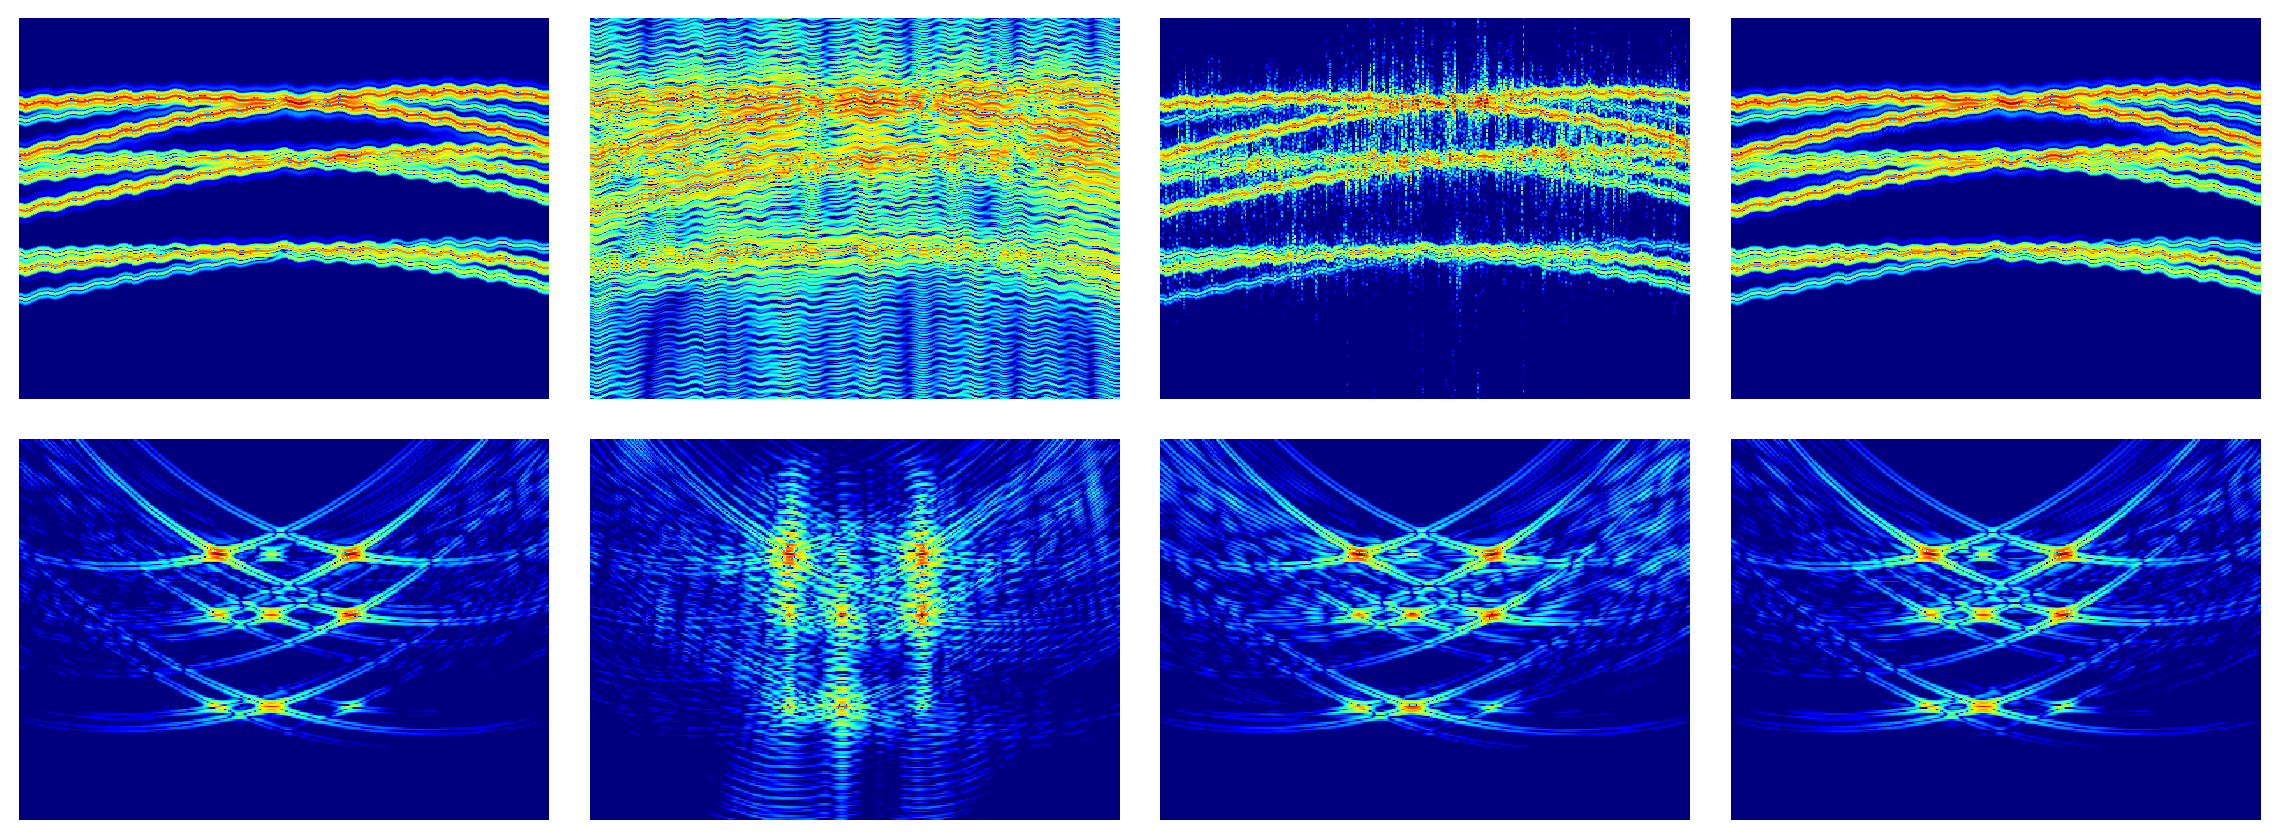

In [9]:
db_range = 50
fig = plt.figure(figsize=(16, 6))

# Original raw data
ax = fig.add_subplot(2, 4, 1)
ax = visualize_raw_data(pimg[0, :, :, 0], ax, db_range=db_range)

# Corrupted raw data
ax = fig.add_subplot(2, 4, 2)
ax = visualize_raw_data(pcond[0, :, :, 0], ax, db_range=db_range)

# OMP-recovered raw data
ax = fig.add_subplot(2, 4, 3)
ax = visualize_raw_data(omp_recontructed, ax, db_range=db_range)

# SARGAN-recovered raw data
ax = fig.add_subplot(2, 4, 4)
ax = visualize_raw_data(gen_img[0, :, :, 0], ax, db_range=db_range)

# Original image
ax = fig.add_subplot(2, 4, 5)
ax = visualize_raw_data(scene_image[0:250, 50:450], ax, db_range=db_range)

# Corrupted image
ax = fig.add_subplot(2, 4, 6)
ax = visualize_raw_data(I_corrupted[0:250, 50:450], ax, db_range=db_range)

# OMP-recovered image
ax = fig.add_subplot(2, 4, 7)
ax = visualize_raw_data(I_omp[0:250, 50:450], ax, db_range=db_range)

# SARGAN-recovered image
ax = fig.add_subplot(2, 4, 8)
ax = visualize_raw_data(I_sargan[0:250, 50:450], ax, db_range=db_range)

plt.tight_layout()

if SAVE_FIGS:
    recovery_filename = scene_type + "_scene_0_8_missing_sargan_omp_image_raw.jpg"
    plt.savefig(os.path.join(output_path, recovery_filename), dpi=300)

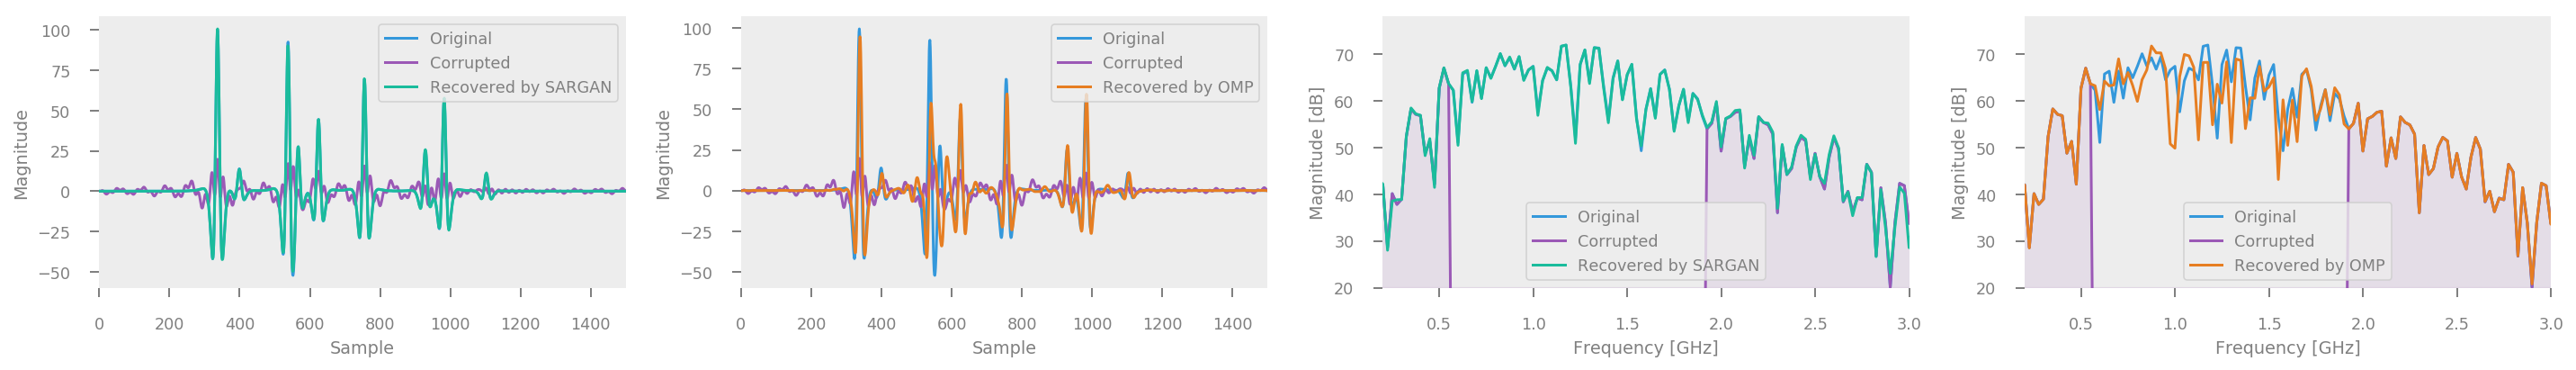

In [10]:
fig = plt.figure(figsize=(20, 3))

# Time domain - one aperture
i_aperture = 0; lw = 1.5
ax = fig.add_subplot(141)
ax.plot(pimg[0, :, i_aperture, 0], color=ori_color, lw=lw, label="Original")
ax.plot(pcond[0, :, i_aperture, 0], color=corrupted_color, lw=lw, label="Corrupted")
ax.plot(gen_img[0, :, i_aperture, 0], color=reconstructed_color, lw=lw, label="Recovered by SARGAN")
ax.set_xlim([0, n_samples])
ax.set_xlabel("Sample"); ax.set_ylabel("Magnitude")
legend_handler = ax.legend(); plt.setp(legend_handler.get_texts(), color='gray')

ax = fig.add_subplot(142)
ax.plot(pimg[0, :, i_aperture, 0], color=ori_color, lw=lw, label="Original")
ax.plot(pcond[0, :, i_aperture, 0], color=corrupted_color, lw=lw, label="Corrupted")
ax.plot(omp_recontructed[:, i_aperture], color=omp_color, lw=lw, label="Recovered by OMP")
ax.set_xlim([0, n_samples])
legend_handler = ax.legend(); plt.setp(legend_handler.get_texts(), color='gray')
ax.set_xlabel("Sample"); ax.set_ylabel("Magnitude")

ori_spectrum = get_spectrum(pimg[0, :, i_aperture, 0], n_fft); ori_spectrum_dB = to_dB(ori_spectrum)
corrupted_spectrum = get_spectrum(pcond[0, :, i_aperture, 0], n_fft); corrupted_spectrum_dB = to_dB(corrupted_spectrum)
corrupted_spectrum_dB[corrupted_spectrum_dB < -200] = -50
sargan_spectrum = get_spectrum(gen_img[0, :, i_aperture, 0], n_fft); sargan_spectrum_dB = to_dB(sargan_spectrum)
omp_spectrum = get_spectrum(omp_recontructed[:, i_aperture], n_fft); omp_spectrum_dB = to_dB(omp_spectrum)
zoom_factor = 8
x_range = [0.2, 3]; y_min = 20
ax = fig.add_subplot(143)
ax.plot(freq[0:n_fft // zoom_factor], ori_spectrum_dB[0:n_fft//zoom_factor], color=ori_color, lw=lw, label="Original")
ax.plot(freq[0:n_fft // zoom_factor], corrupted_spectrum_dB[0:n_fft//zoom_factor], color=corrupted_color, lw=lw, label="Corrupted")
ax.plot(freq[0:n_fft // zoom_factor], sargan_spectrum_dB[0:n_fft//zoom_factor], color=reconstructed_color, lw=lw, label="Recovered by SARGAN")
ax.fill_between(freq[0:n_fft // zoom_factor], corrupted_spectrum_dB[0:n_fft//zoom_factor], y_min, color=corrupted_color, alpha=0.1)
ax.set_ylim(ymin=y_min); ax.set_xlim(x_range)
# ax.set_title("Spectrum: deterministic scene", color="gray")
ax.set_xlabel("Frequency [GHz]"); ax.set_ylabel("Magnitude [dB]")
legend_handler = ax.legend(); plt.setp(legend_handler.get_texts(), color='gray')

ax = fig.add_subplot(144)
ax.plot(freq[0:n_fft // zoom_factor], ori_spectrum_dB[0:n_fft//zoom_factor], color=ori_color, lw=lw, label="Original")
ax.plot(freq[0:n_fft // zoom_factor], corrupted_spectrum_dB[0:n_fft//zoom_factor], color=corrupted_color, lw=lw, label="Corrupted")
ax.plot(freq[0:n_fft // zoom_factor], omp_spectrum_dB[0:n_fft//zoom_factor], color=omp_color, lw=lw, label="Recovered by OMP")
ax.fill_between(freq[0:n_fft // zoom_factor], corrupted_spectrum_dB[0:n_fft//zoom_factor], y_min, color=corrupted_color, alpha=0.1)
ax.set_ylim(ymin=y_min); ax.set_xlim(x_range)
# # ax.set_title("Spectrum: deterministic scene", color="gray")
ax.set_xlabel("Frequency [GHz]"); ax.set_ylabel("Magnitude [dB]")
legend_handler = ax.legend(); plt.setp(legend_handler.get_texts(), color='gray')

plt.tight_layout()

if SAVE_FIGS:
    recovery_filename = scene_type + "_scene_0_8_missing_sargan_omp_one_aperture.jpg"
    plt.savefig(os.path.join(output_path, recovery_filename), dpi=300)

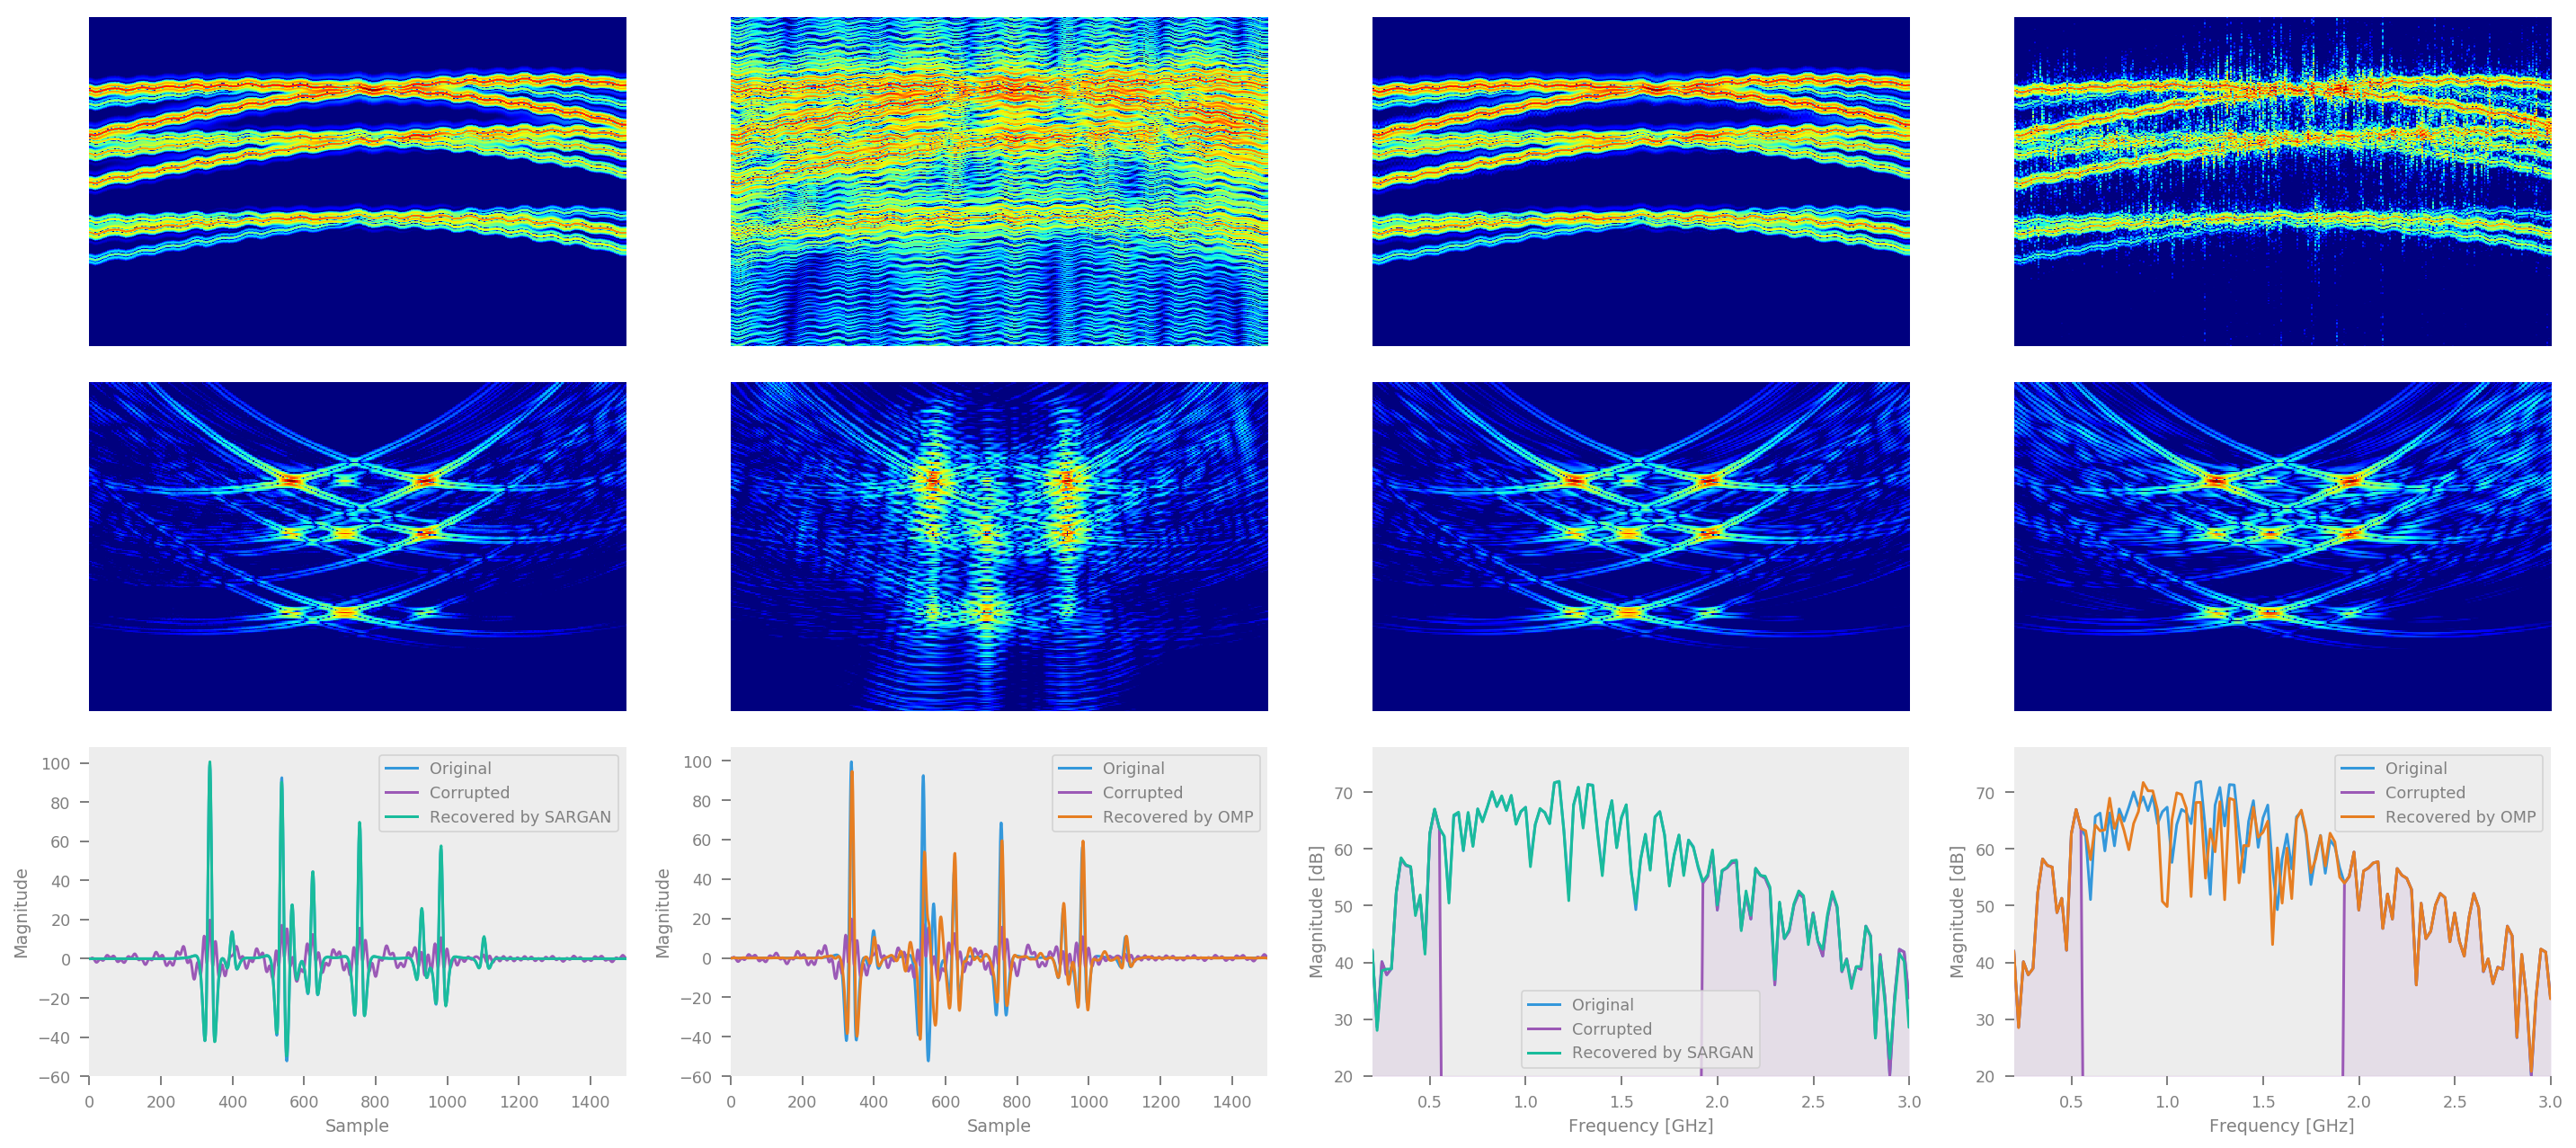

In [13]:
db_range = 50
fig = plt.figure(figsize=(20, 9))

# Original raw data
ax = fig.add_subplot(3, 4, 1)
ax = visualize_raw_data(pimg[0, :, :, 0], ax, db_range=db_range)

# Corrupted raw data
ax = fig.add_subplot(3, 4, 2)
ax = visualize_raw_data(pcond[0, :, :, 0], ax, db_range=db_range)

# SARGAN-recovered raw data
ax = fig.add_subplot(3, 4, 3)
ax = visualize_raw_data(gen_img[0, :, :, 0], ax, db_range=db_range)

# OMP-recovered raw data
ax = fig.add_subplot(3, 4, 4)
ax = visualize_raw_data(omp_recontructed, ax, db_range=db_range)

# Original image
ax = fig.add_subplot(3, 4, 5)
ax = visualize_raw_data(scene_image[0:250, 50:450], ax, db_range=db_range)

# Corrupted image
ax = fig.add_subplot(3, 4, 6)
ax = visualize_raw_data(I_corrupted[0:250, 50:450], ax, db_range=db_range)

# SARGAN-recovered image
ax = fig.add_subplot(3, 4, 7)
ax = visualize_raw_data(I_sargan[0:250, 50:450], ax, db_range=db_range)

# OMP-recovered image
ax = fig.add_subplot(3, 4, 8)
ax = visualize_raw_data(I_omp[0:250, 50:450], ax, db_range=db_range)

# Time domain - one aperture
i_aperture = 0; lw = 1.5
ax = fig.add_subplot(349)
ax.plot(pimg[0, :, i_aperture, 0], color=ori_color, lw=lw, label="Original")
ax.plot(pcond[0, :, i_aperture, 0], color=corrupted_color, lw=lw, label="Corrupted")
ax.plot(gen_img[0, :, i_aperture, 0], color=reconstructed_color, lw=lw, label="Recovered by SARGAN")
ax.set_xlim([0, n_samples])
ax.set_xlabel("Sample"); ax.set_ylabel("Magnitude")
legend_handler = ax.legend(); plt.setp(legend_handler.get_texts(), color='gray')

ax = fig.add_subplot(3, 4, 10)
ax.plot(pimg[0, :, i_aperture, 0], color=ori_color, lw=lw, label="Original")
ax.plot(pcond[0, :, i_aperture, 0], color=corrupted_color, lw=lw, label="Corrupted")
ax.plot(omp_recontructed[:, i_aperture], color=omp_color, lw=lw, label="Recovered by OMP")
ax.set_xlim([0, n_samples])
legend_handler = ax.legend(); plt.setp(legend_handler.get_texts(), color='gray')
ax.set_xlabel("Sample"); ax.set_ylabel("Magnitude")

ori_spectrum = get_spectrum(pimg[0, :, i_aperture, 0], n_fft); ori_spectrum_dB = to_dB(ori_spectrum)
corrupted_spectrum = get_spectrum(pcond[0, :, i_aperture, 0], n_fft); corrupted_spectrum_dB = to_dB(corrupted_spectrum)
corrupted_spectrum_dB[corrupted_spectrum_dB < -200] = -50
sargan_spectrum = get_spectrum(gen_img[0, :, i_aperture, 0], n_fft); sargan_spectrum_dB = to_dB(sargan_spectrum)
omp_spectrum = get_spectrum(omp_recontructed[:, i_aperture], n_fft); omp_spectrum_dB = to_dB(omp_spectrum)
zoom_factor = 8
x_range = [0.2, 3]; y_min = 20
ax = fig.add_subplot(3, 4, 11)
ax.plot(freq[0:n_fft // zoom_factor], ori_spectrum_dB[0:n_fft//zoom_factor], color=ori_color, lw=lw, label="Original")
ax.plot(freq[0:n_fft // zoom_factor], corrupted_spectrum_dB[0:n_fft//zoom_factor], color=corrupted_color, lw=lw, label="Corrupted")
ax.plot(freq[0:n_fft // zoom_factor], sargan_spectrum_dB[0:n_fft//zoom_factor], color=reconstructed_color, lw=lw, label="Recovered by SARGAN")
ax.fill_between(freq[0:n_fft // zoom_factor], corrupted_spectrum_dB[0:n_fft//zoom_factor], y_min, color=corrupted_color, alpha=0.1)
ax.set_ylim(ymin=y_min); ax.set_xlim(x_range)
# ax.set_title("Spectrum: deterministic scene", color="gray")
ax.set_xlabel("Frequency [GHz]"); ax.set_ylabel("Magnitude [dB]")
legend_handler = ax.legend(); plt.setp(legend_handler.get_texts(), color='gray')

ax = fig.add_subplot(3, 4, 12)
ax.plot(freq[0:n_fft // zoom_factor], ori_spectrum_dB[0:n_fft//zoom_factor], color=ori_color, lw=lw, label="Original")
ax.plot(freq[0:n_fft // zoom_factor], corrupted_spectrum_dB[0:n_fft//zoom_factor], color=corrupted_color, lw=lw, label="Corrupted")
ax.plot(freq[0:n_fft // zoom_factor], omp_spectrum_dB[0:n_fft//zoom_factor], color=omp_color, lw=lw, label="Recovered by OMP")
ax.fill_between(freq[0:n_fft // zoom_factor], corrupted_spectrum_dB[0:n_fft//zoom_factor], y_min, color=corrupted_color, alpha=0.1)
ax.set_ylim(ymin=y_min); ax.set_xlim(x_range)
# # ax.set_title("Spectrum: deterministic scene", color="gray")
ax.set_xlabel("Frequency [GHz]"); ax.set_ylabel("Magnitude [dB]")
legend_handler = ax.legend(); plt.setp(legend_handler.get_texts(), color='gray')

plt.tight_layout()
if SAVE_FIGS:
    recovery_filename = scene_type + "_scene_0_8_missing_sargan_omp_image_raw_one_aperture.jpg"
    plt.savefig(os.path.join(output_path, recovery_filename), dpi=300)